In [1]:
import random as rd, numpy as np, torch

rd.seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.backends.cudnn.determenistic = True

Скачиваем тренировочные и тестовые данные из датасета:

In [2]:
import torchvision.datasets

MNIST_train = torchvision.datasets.MNIST('/', download=True)
MNIST_test = torchvision.datasets.MNIST('/', download=True, train=False)

/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


Конвертируем **features** в float:

In [3]:
x_train = MNIST_train.data
y_train = MNIST_train.targets
x_test = MNIST_test.data
y_test = MNIST_test.targets
x_train.dtype, y_train.dtype

(torch.uint8, torch.int64)

In [4]:
x_train, x_test = x_train.float(), x_test.float()
x_train.shape, y_train.shape, x_test.shape, y_test.shape

(torch.Size([60000, 28, 28]),
 torch.Size([60000]),
 torch.Size([10000, 28, 28]),
 torch.Size([10000]))

Пример изображения из датасета:

tensor(5)

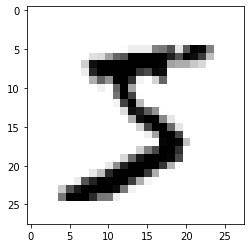

In [5]:
import matplotlib.pyplot as plt

plt.imshow(x_train[0], cmap='binary')
y_train[0]

Преобразуем размерность **features** так, чтобы каждому объекту соответствовал одномерный массив:

In [6]:
x_train, x_test = x_train.reshape(-1, 28*28), x_test.reshape(-1, 28*28)
x_train.shape, x_test.shape

(torch.Size([60000, 784]), torch.Size([10000, 784]))

Определяем класс нейронной сети:

In [7]:
class NumNet(torch.nn.Module):
  def __init__(self, n_neurons):
    super().__init__()
    self.fc1 = torch.nn.Linear(28*28, n_neurons)
    self.act1 = torch.nn.Sigmoid()
    self.fc2 = torch.nn.Linear(n_neurons, 10)
  def forward(self, x):
    x = self.act1(self.fc1(x))
    return self.fc2(x)

Инициализируем нейронную сеть, функцию потерь и метод оптимизации:

In [8]:
net = NumNet(100)
loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=0.0001)

Проверяем статус GPU и переносим инициализированный класс сети (тензоры параметров) и тестовые тензоры на видеопамять если CUDA доступна. Тренировочные данные будем переносить в видеопамять по частям (**batch**) в процессе обучения, так как в общем случае весь датасет может не поместиться на видеокарту.

In [9]:
!nvidia-smi

Sun Sep 26 08:24:15 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.63.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P8    28W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [10]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
net = net.to(device) # net.to('cuda:0'), net.cuda() - alternatives
x_test, y_test = x_test.to(device), y_test.to(device)

Обучаем нейросеть, сохраняя промежуточне значения точности и функции потерь для каждой эпохи на тренировочных и тестовых данных. Для тренировочных данных вычисляются средние значения по частям (**batch**).

In [12]:
batch_size, train_len = 1000, len(x_train)
train_accuracy, train_loss = [], []
test_accuracy, test_loss = [], []

for epoch in range(30):
  order = np.random.permutation(train_len)
  batch_accuracy, batch_loss = 0, 0
  for i in range(0, train_len, batch_size):
    optimizer.zero_grad()
    ind = order[i:i+batch_size]
    x_batch = x_train[ind].to(device)
    y_batch = y_train[ind].to(device)
    raw_out = net.forward(x_batch)
    loss_val = loss(raw_out, y_batch)
    loss_val.backward()
    optimizer.step()

    batch_accuracy += (raw_out.argmax(dim=1)==y_batch).float().mean()
    batch_loss += loss_val

  train_accuracy.append(batch_accuracy/(train_len/batch_size))
  train_loss.append(batch_loss/(train_len/batch_size))
  raw_out = net.forward(x_test)
  test_accuracy.append((raw_out.argmax(dim=1)==y_test).float().mean())
  test_loss.append(loss(raw_out, y_test))

Сравниваем изменение точности и функции потерь для тренировочных и тестовых данных:

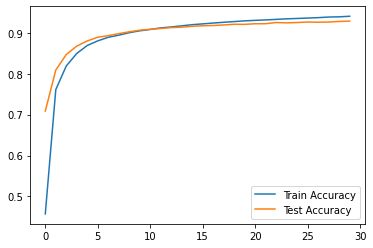

In [13]:
plt.plot(train_accuracy, label='Train Accuracy')
plt.plot(test_accuracy, label='Test Accuracy')
plt.legend();

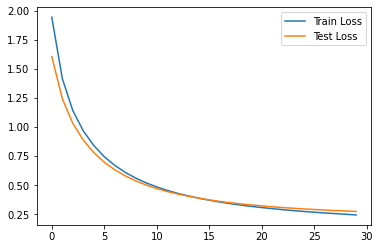

In [14]:
plt.plot(train_loss, label='Train Loss')
plt.plot(test_loss, label='Test Loss')
plt.legend();